In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from scipy.stats import norm
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.cdf import get_cdf
from NCP.nn.losses import CMELoss
from NCP.utils import smooth_cdf
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp
import lightning as L
from NCP.nn.callbacks import LitProgressBar
from scipy.stats import laplace, cauchy, bernoulli, pareto

from NCP.examples.tools.plot_utils import setup_plots, plot_expectation
from NCP.examples.tools.data_gen import gen_additive_noise_data
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

symatrised pareto distribution

# Laplace noise

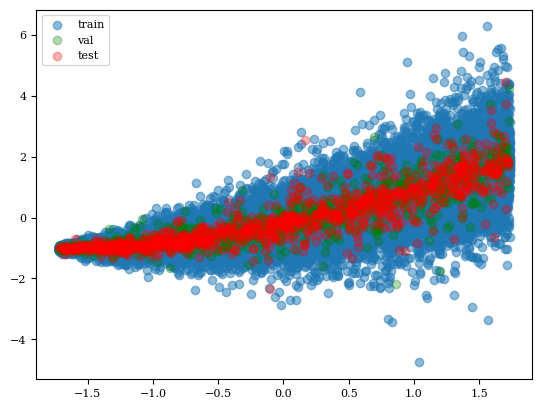

In [5]:
laplace_noise = lambda x : laplace.rvs(loc=0, scale=x)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(laplace_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 49999, loss = -2.1428463459014893: 100%|██████████| 50000/50000 [28:21<00:00, 29.39it/s]


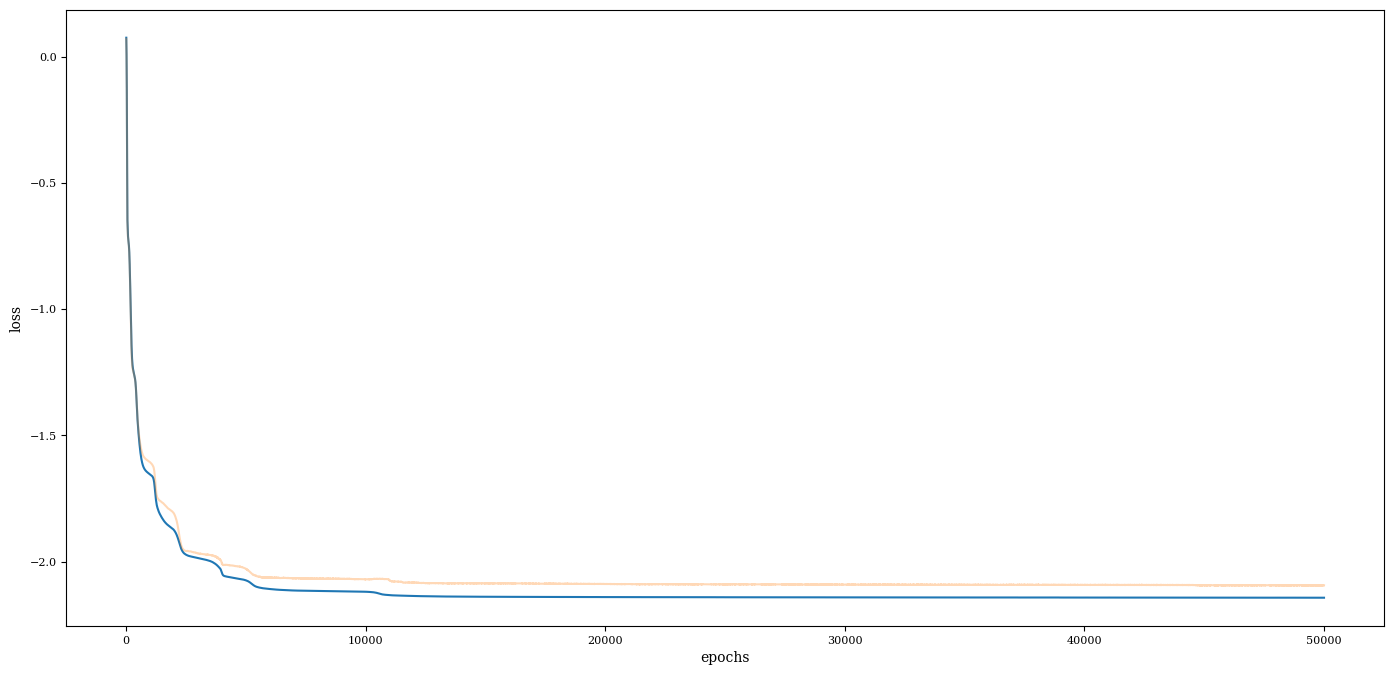

In [6]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

laplace_reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    laplace_reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

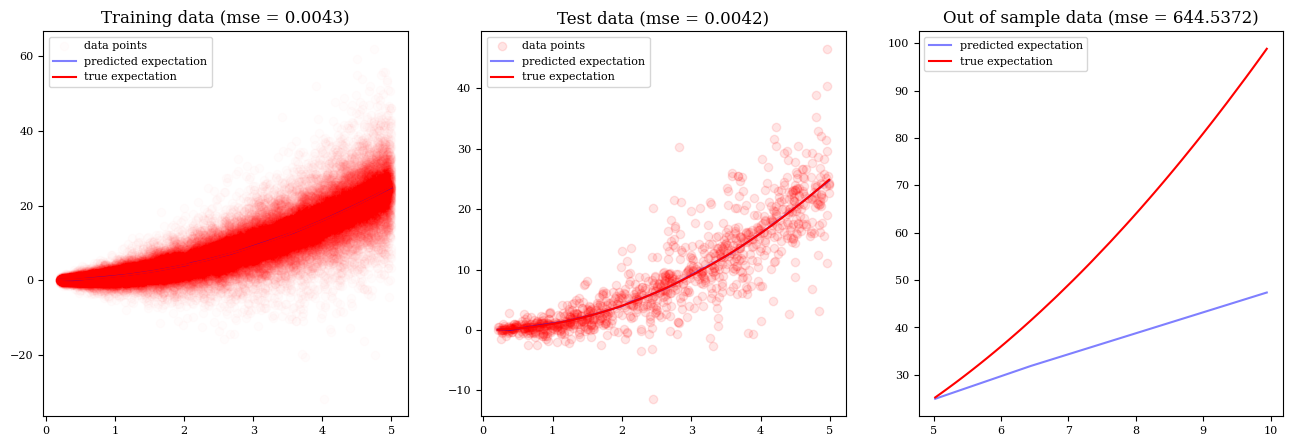

In [7]:
plot_expectation(laplace_reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: 2.025768269213933
- Hellinger: 1.1103584393296364
result for x= 1
- KL: 0.7714035768814906
- Hellinger: 0.3207626736991175
result for x= 3
- KL: 0.6069520203976047
- Hellinger: 0.23377870048159052
result for x= 4.5
- KL: 0.6047253500732852
- Hellinger: 0.2287794835559116


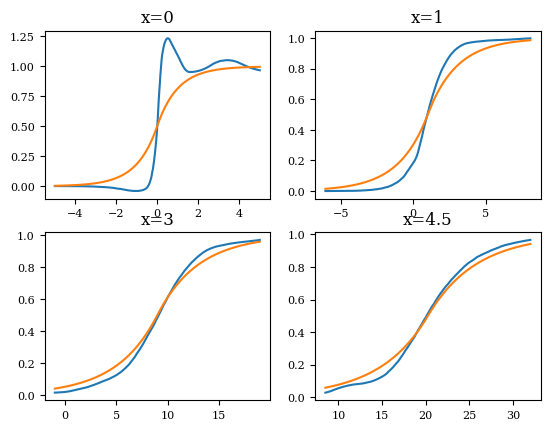

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(laplace_reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = laplace.cdf(fys, loc=xi**2, scale=1+xi)

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()

# Cauchy noise

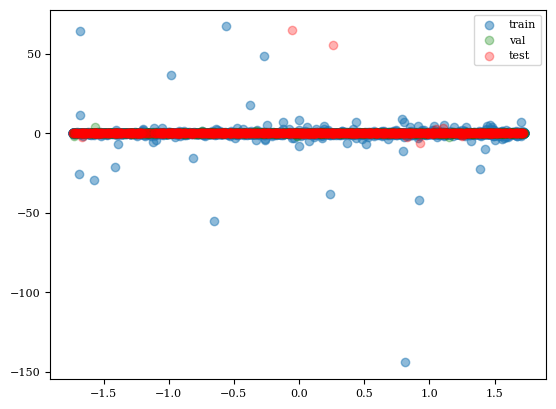

In [15]:
cauchy_noise = lambda x : cauchy.rvs(loc=0, scale=1+x)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(cauchy_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 49999, loss = -39.93330001831055: 100%|██████████| 50000/50000 [25:44<00:00, 32.36it/s] 


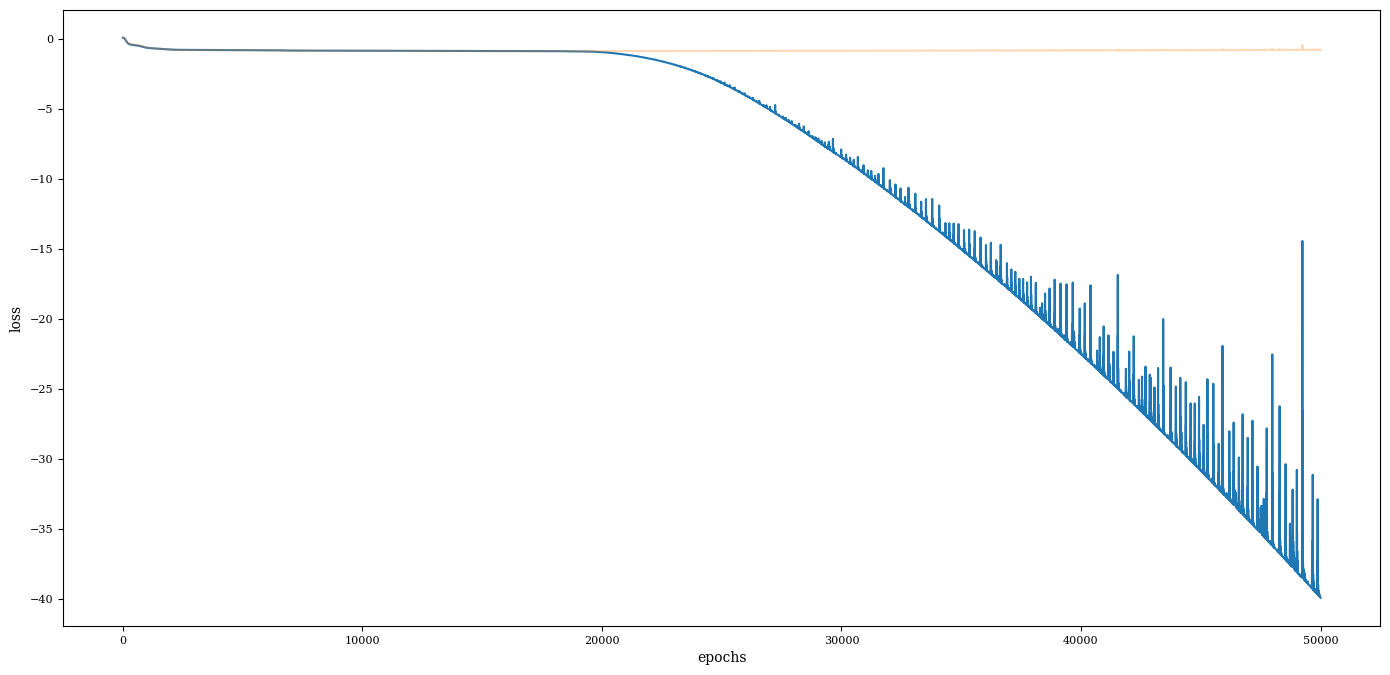

In [16]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

cauchy_reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    cauchy_reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

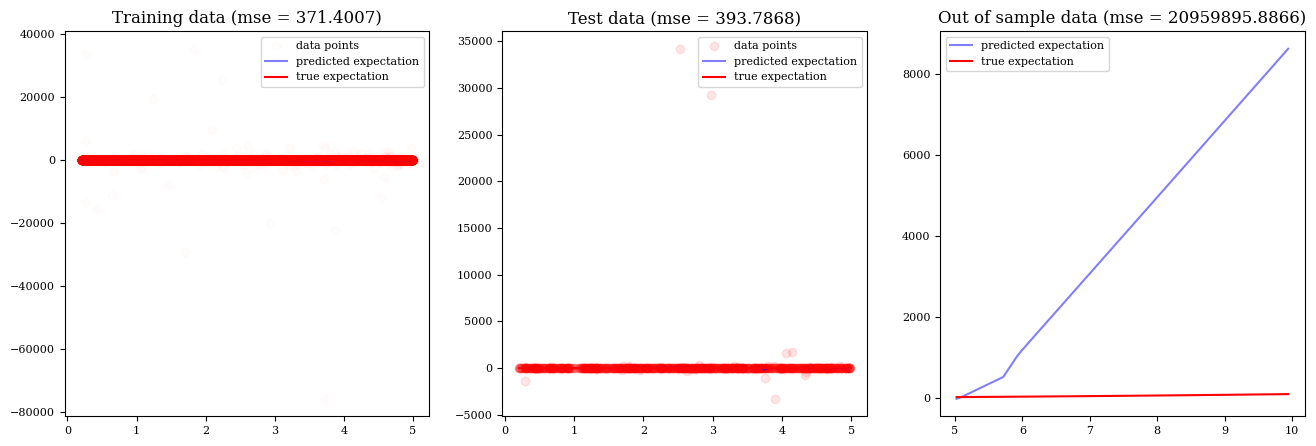

In [17]:
plot_expectation(cauchy_reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: 0.6339397089841504
- Hellinger: 0.2580952818335685
result for x= 1
- KL: 0.46296147998968123
- Hellinger: 0.1868691416435469
result for x= 3
- KL: 0.4386493044392724
- Hellinger: 0.17600921378623074
result for x= 4.5
- KL: 0.3846038270424623
- Hellinger: 0.165559679348731


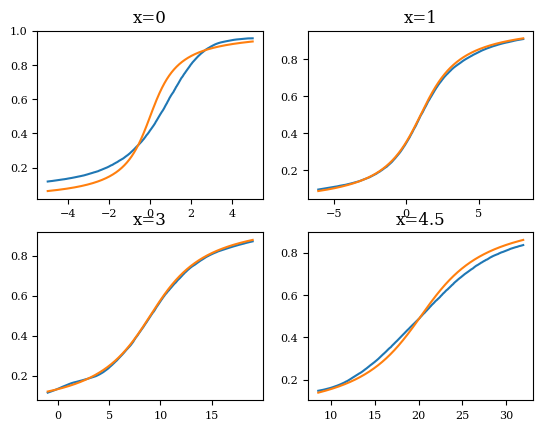

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(cauchy_reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = cauchy.cdf(fys, loc=xi**2, scale=1+xi)

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')

plt.show()

# Pareto noise

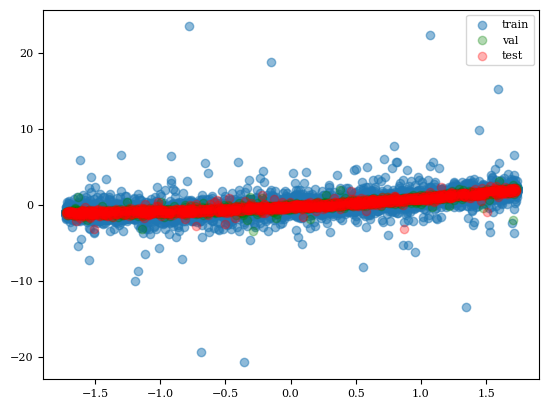

In [31]:
def sym_pareto_cdf(x, scale):
    x_neg = (x<0)
    x_pos = (x>0)
    cdf_x_pos = pareto.cdf(x, scale)
    cdf_x_neg = 1-pareto.cdf(-x, scale)
    return 0.5* cdf_x_neg *  x_neg + (0.5+ 0.5 * cdf_x_pos) *  x_pos

pareto_noise = lambda x : pareto.rvs(2)* (2*bernoulli.rvs(0.5)-1)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(pareto_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 49999, loss = -4.368854522705078: 100%|██████████| 50000/50000 [30:07<00:00, 27.67it/s] 


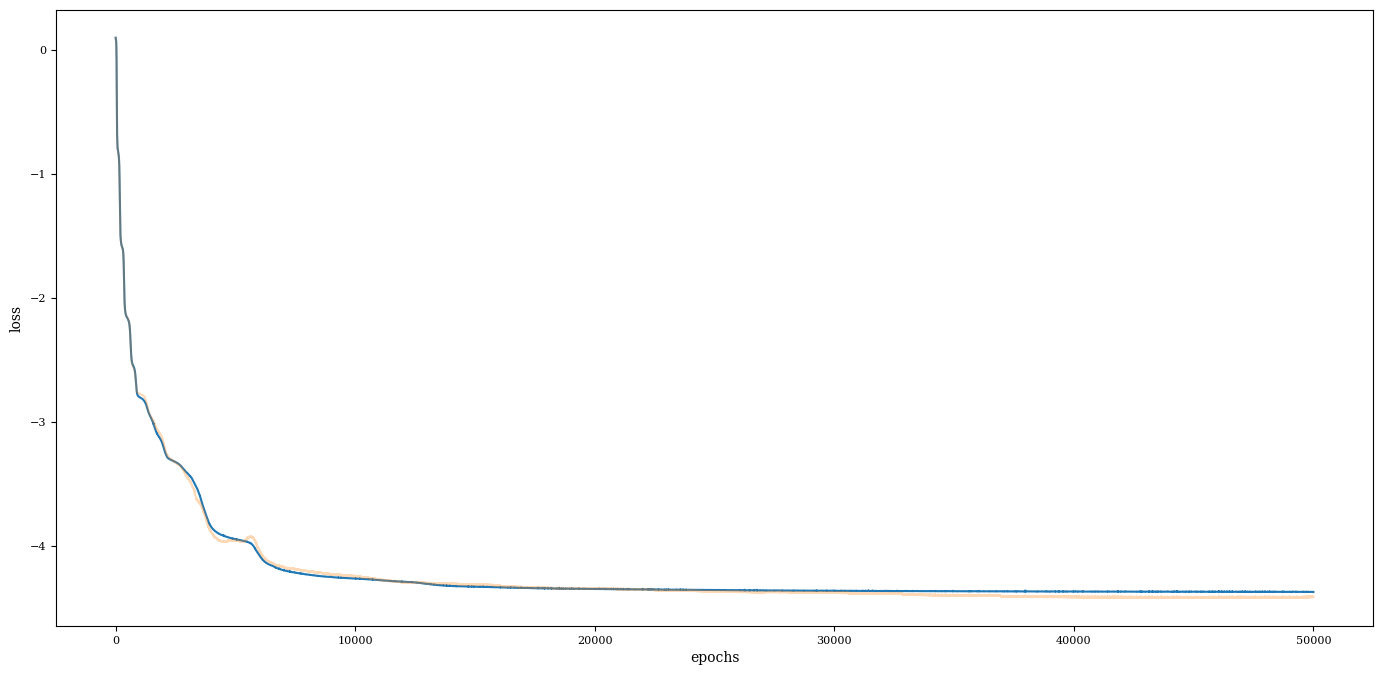

In [28]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

pareto_reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    pareto_reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

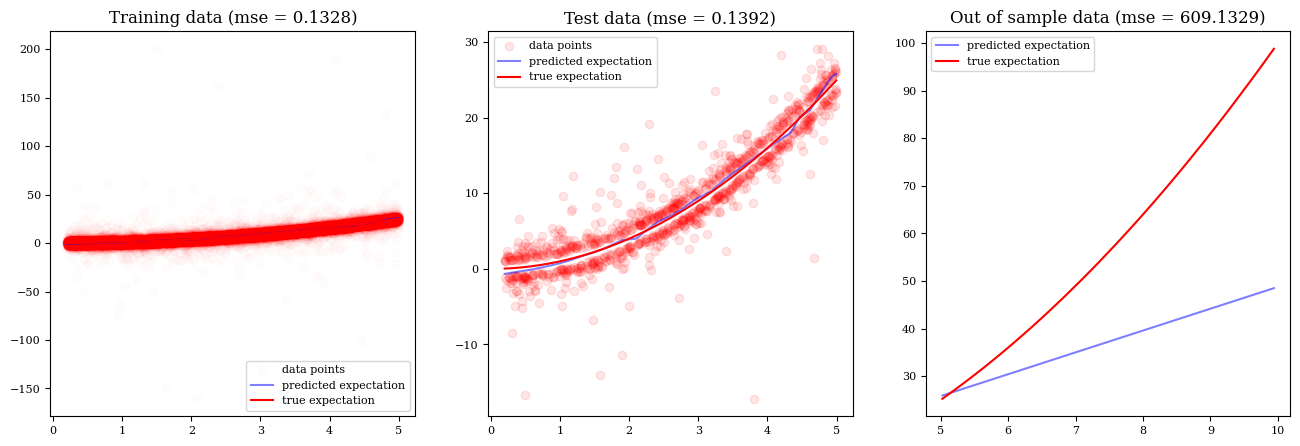

In [29]:
plot_expectation(pareto_reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: inf
- Hellinger: 0.48825243600600726


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 1
- KL: inf
- Hellinger: 0.4568796621346792


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 3
- KL: inf
- Hellinger: 0.6198143242999391


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 4.5
- KL: inf
- Hellinger: 0.7076717248550572


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


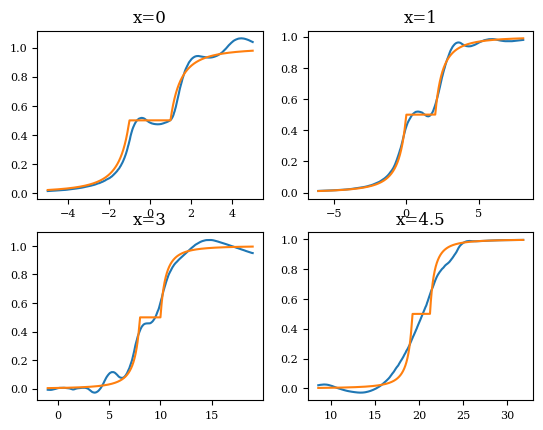

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(pareto_reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = sym_pareto_cdf(fys-xi**2, 2)

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()